In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [3]:
df=pd.read_excel('data.xlsx',index_col=0)
df1 = pd.read_excel("data.xlsx", sheet_name=1,index_col=0)
df=df.join(df1)
meanreturn = df.mean(axis=0)
df2=meanreturn.to_frame()
df2.columns=['mean']
df2['std']=df.std()
df2['sharperatio']=((df2['mean']-df2.iloc[-8,0])/df2['std'])
df3=df2.iloc[:-9,:]

In [4]:
df_rolling=df
industry= df.columns[:-9]
df_rolling_avg = df_rolling.rolling(window=12).mean()
df_rolling_avg.to_excel('my_dataframe.xlsx', index=1)

In [5]:
#print(df_rolling_avg)

In [6]:
X=df[['Mkt-RF','SMB', 'HML']]
X = sm.add_constant(X)
X2=df[['Mkt-RF','SMB', 'HML','CMA','RMW']]
X2 = sm.add_constant(X2)

In [7]:
for i in industry:
    Y = df[i]-df['RF']
    ks = sm.OLS(Y, X)
    ks_res =ks.fit()
    print("this is the Fama French 3 factor regression "+i) 
    print(ks_res.params)
    ks_5 = sm.OLS(Y, X2)
    ks_5_res =ks_5.fit()
    print("this is the Fama French 5 factor regression "+i) 
    print(ks_5_res.params)


this is the Fama French 3 factor regression Food 
const     0.207251
Mkt-RF    0.756290
SMB      -0.174928
HML       0.149495
dtype: float64
this is the Fama French 5 factor regression Food 
const    -0.058861
Mkt-RF    0.821386
SMB      -0.042369
HML      -0.030894
CMA       0.367428
RMW       0.555533
dtype: float64
this is the Fama French 3 factor regression Beer 
const     0.303505
Mkt-RF    0.781304
SMB      -0.128190
HML       0.073041
dtype: float64
this is the Fama French 5 factor regression Beer 
const     0.009302
Mkt-RF    0.852193
SMB       0.020292
HML      -0.121156
CMA       0.392835
RMW       0.622673
dtype: float64
this is the Fama French 3 factor regression Smoke
const     0.504421
Mkt-RF    0.737316
SMB      -0.247782
HML       0.217172
dtype: float64
this is the Fama French 5 factor regression Smoke
const     0.128737
Mkt-RF    0.847871
SMB      -0.094065
HML      -0.128067
CMA       0.750282
RMW       0.637184
dtype: float64
this is the Fama French 3 factor regress

In [8]:
df3.to_excel('industry performance.xlsx', index=1)

In [9]:
#Define EXCESS RETURNS, standard deviation and correlations of the assets
mu_1 = df3['mean']- df2.iloc[-8,0]
sd_1 = df3['std']
CORR_1 = df.loc[:,"Food ":'Other'].corr()

In [10]:
#Get the covariance and inverted covariance matrix
V = np.diag(sd_1) @ CORR_1 @ np.diag(sd_1) 
V_1 = np.linalg.inv(V)
#Get weights for Tangency and MVP portfolio
ones = np.ones(len(mu_1))
w_mvp = (V_1 @ ones) / (ones.T @ V_1 @ ones) 
w_T = (V_1 @ mu_1) / (ones.T @ V_1 @ mu_1)
#Calculate the returns and variance of Tangency & MVP
r_mvp = w_mvp @ mu_1; sig_mvp = np.sqrt(w_mvp.T @ V @ w_mvp) 
r_T = w_T @ mu_1; sig_T = np.sqrt(w_T.T @ V @ w_T)
#Get nx2 matrix of returns and ones for each assets -> Calculate fundamental matrix A
L = np.asarray([list(mu_1), list(np.ones(len(mu_1)))]).T 
A = L.T @ V_1 @ L

In [11]:
def sig_2(r_p, A_p): 
    sig_p_2 = (A_p[0,0]-2*A_p[0,1]*r_p+A_p[1,1]*r_p**2)/(A_p[0,0]*A_p[1,1]-A_p[0,1]**2) 
    return sig_p_2, r_p, r_p/np.sqrt(sig_p_2)

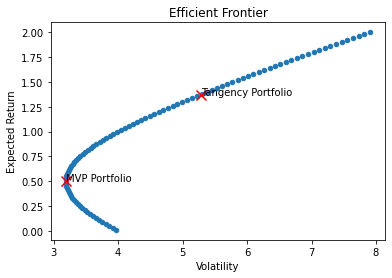

In [12]:
#Define 50 returns from 1% to 21% to calculate corresponding Mean-Variance efficient portfolio
rets = np.linspace(0.01,2,100) 
sigs = np.zeros(100)
for i, ret in enumerate(rets):
    sigs[i] = np.sqrt(sig_2(rets[i], A)[0])
df_front = pd.DataFrame([sigs,rets], index=['sig','ret']).T
#Plot the efficient frontier with MVP & Tangency portfolio
df_front.plot.scatter('sig', 'ret')
#Plot MVP
plt.scatter(sig_mvp, r_mvp, marker = 'x', s = 100, color = 'red') 
plt.annotate('MVP Portfolio', xy = (sig_mvp+0.004, r_mvp))
#Plot Tangency
plt.scatter(sig_T, r_T, marker = 'x', s = 100, color = 'red') 
plt.annotate('Tangency Portfolio', xy = (sig_T+0.004, r_T-0.008)) 
plt.xlabel('Volatility'); plt.ylabel('Expected Return') 
plt.title('Efficient Frontier')
plt.show()

In [13]:
plt.clf()

<Figure size 432x288 with 0 Axes>

Annualized Return and Standard deviation

In [14]:
print(r_T*12,np.sqrt(12)*sig_T)

16.47193055776199 18.295329975444584


In [15]:
a=0
for i in industry:
    print(i,w_T[a])
    a+=1
    

Food  -0.046827906881665896
Beer  0.31419634898755566
Smoke 0.38706414205392375
Games 0.01116332867783123
Books -0.2916341354200865
Hshld -0.2145024489694738
Clths 0.12693401945232913
Hlth  0.25883458057652026
Chems -0.063954553466104
Txtls 0.11128521020768979
Cnstr -0.511447773319404
Steel -0.39286087758558913
FabPr 0.3340934515043266
ElcEq 0.2917649536122062
Autos 0.09110443367973672
Carry 0.21231191160502047
Mines 0.13348001100165846
Coal  -0.017672571746659715
Oil   0.14489508626625358
Util  0.2399326924885278
Telcm -0.009269658688922482
Servs 0.23122996181372707
BusEq 0.06395532280250171
Paper 0.0006720820164193398
Trans 0.04738526413857546
Whlsl 0.04022751964093319
Rtail 0.17342631151205828
Meals 0.1383052272684631
Fin   0.09953042498088949
Other -0.9036223582092411


In [16]:
esg=["Food ", 'Hlth ','Util ','Telcm','BusEq','Fin  ']
nonsin=df[esg]
nonsin_1=df3.loc[esg]

In [17]:
#Define EXCESS RETURNS, standard deviation and correlations of the assets
mu_2 = nonsin_1['mean']- df2.iloc[-8,0]
sd_2 = nonsin_1['std']
CORR_2 = nonsin.corr()

In [18]:
#Get the covariance and inverted covariance matrix
V = np.diag(sd_2) @ CORR_2 @ np.diag(sd_2) 
V_1 = np.linalg.inv(V)
#Get weights for Tangency and MVP portfolio
ones = np.ones(len(mu_2))
w_mvp = (V_1 @ ones) / (ones.T @ V_1 @ ones) 
w_T = (V_1 @ mu_2) / (ones.T @ V_1 @ mu_2)
#Calculate the returns and variance of Tangency & MVP
r_mvp = w_mvp @ mu_2; sig_mvp = np.sqrt(w_mvp.T @ V @ w_mvp) 
r_T = w_T @ mu_2; sig_T = np.sqrt(w_T.T @ V @ w_T)
#Get nx2 matrix of returns and ones for each assets -> Calculate fundamental matrix A
L = np.asarray([list(mu_2), list(np.ones(len(mu_2)))]).T 
A = L.T @ V_1 @ L

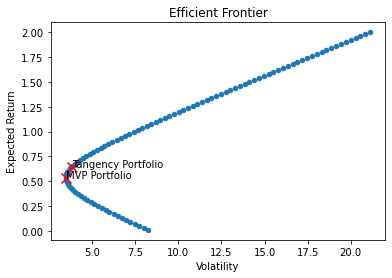

In [19]:
#Define 50 returns from 1% to 21% to calculate corresponding Mean-Variance efficient portfolio
rets = np.linspace(0.01,2,100) 
sigs = np.zeros(100)
for i, ret in enumerate(rets):
    sigs[i] = np.sqrt(sig_2(rets[i], A)[0])
df_front = pd.DataFrame([sigs,rets], index=['sig','ret']).T
#Plot the efficient frontier with MVP & Tangency portfolio
df_front.plot.scatter('sig', 'ret')
#Plot MVP
plt.scatter(sig_mvp, r_mvp, marker = 'x', s = 100, color = 'red') 
plt.annotate('MVP Portfolio', xy = (sig_mvp+0.004, r_mvp))
#Plot Tangency
plt.scatter(sig_T, r_T, marker = 'x', s = 100, color = 'red') 
plt.annotate('Tangency Portfolio', xy = (sig_T+0.004, r_T-0.008)) 
plt.xlabel('Volatility'); plt.ylabel('Expected Return') 
plt.title('Efficient Frontier')
plt.show()

Annualized Return and Standard deviation

In [20]:
print(r_T*12,np.sqrt(12)*sig_T)

7.7625931429483765 13.231721518967547


In [21]:
a=0
for i in esg:
    print(i,w_T[a])
    a+=1

Food  0.45636706756144546
Hlth  0.34214804910814084
Util  0.24332295522117664
Telcm -0.015731222316168733
BusEq 0.15027820949837073
Fin   -0.1763850590729648
